In [1]:
import networkx as nx
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
G_fb = nx.read_edgelist("Group7/Facebook-Ego/1912.edges", create_using = nx.Graph(), nodetype = int)
num_edges = G_fb.number_of_edges()
print("Number of edges:", num_edges)

Number of edges: 1235


## Feature engineering

In [3]:
# Function to create negative samples (pairs of nodes not connected)
def get_negative_edges(graph, num_neg_samples):
    negative_edges = []
    all_nodes = list(graph.nodes())
    while len(negative_edges) < num_neg_samples:
        node1, node2 = random.sample(all_nodes, 2)
        if not graph.has_edge(node1, node2):
            negative_edges.append((node1, node2))
    return negative_edges


In [16]:
# Split the edges into training and test sets (90% train, 10% test)
train_edges, test_edges = train_test_split(list(G_fb.edges()), test_size=0.1, random_state=42)

# Remove test edges from the graph
G_train = G_fb.copy()
G_train.remove_edges_from(test_edges)

# Generate negative samples for training and testing
negative_edges_train = get_negative_edges(G_train, len(train_edges))
negative_edges_test = get_negative_edges(G_fb, len(test_edges))


In [17]:
# Combine positive and negative samples for training and testing
train_edges_with_labels = [(edge, 1) for edge in train_edges] + [(edge, 0) for edge in negative_edges_train]
test_edges_with_labels = [(edge, 1) for edge in test_edges] + [(edge, 0) for edge in negative_edges_test]

we'll create features for the link prediction task. Commonly used features in graph data include:

    Number of Common Neighbors: Nodes with more common neighbors are more likely to be connected.
    Jaccard Coefficient: Measures similarity between the sets of neighbors.
    Preferential Attachment: Nodes with high degrees are more likely to create links.

In [18]:
# Function to compute features for a pair of nodes
def compute_features(graph, edge):
    u, v = edge
    cn = len(list(nx.common_neighbors(graph, u, v))) # Common Neighbors
    jc = list(nx.jaccard_coefficient(graph, [(u, v)]))[0][2] # Jaccard Coefficient
    pa = list(nx.preferential_attachment(graph, [(u, v)]))[0][2] # Preferential Attachment
    return cn, jc, pa



In [19]:
# Compute features for training and testing data
X_train = [compute_features(G_train, edge) for edge, label in train_edges_with_labels]
y_train = [label for edge, label in train_edges_with_labels]

X_test = [compute_features(G_train, edge) for edge, label in test_edges_with_labels]
y_test = [label for edge, label in test_edges_with_labels]

len(X_train), len(X_test)  

(2222, 248)

In [20]:
X_train[:5], y_train[:5] 

([(5, 0.11627906976744186, 476),
  (9, 0.32142857142857145, 312),
  (23, 0.6571428571428571, 837),
  (11, 0.3548387096774194, 416),
  (17, 0.6071428571428571, 504)],
 [1, 1, 1, 1, 1])

## Modeling

In [21]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Predictions
y_pred = model_lr.predict(X_test)
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUROC:", auroc)
print("Precision:", precision)


Accuracy: 0.875
AUROC: 0.9541818418314255
Precision: 0.911504424778761


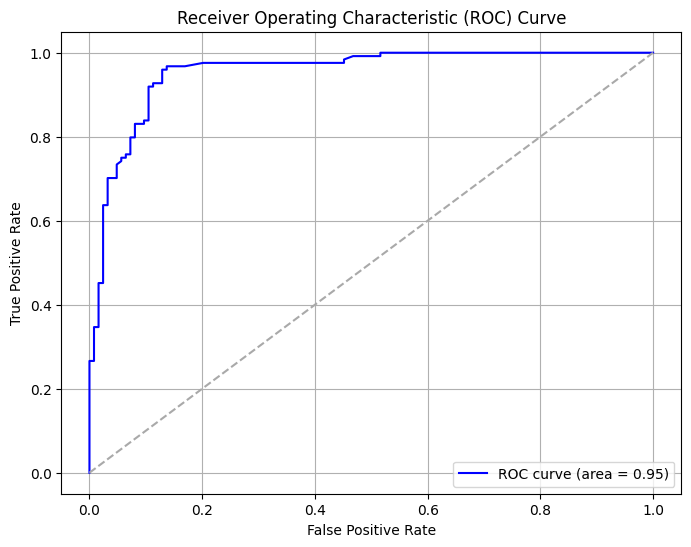

In [22]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [23]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Predictions
y_pred = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUROC:", auroc)
print("Precision:", precision)

Accuracy: 0.8709677419354839
AUROC: 0.9358415712799169
Precision: 0.9107142857142857


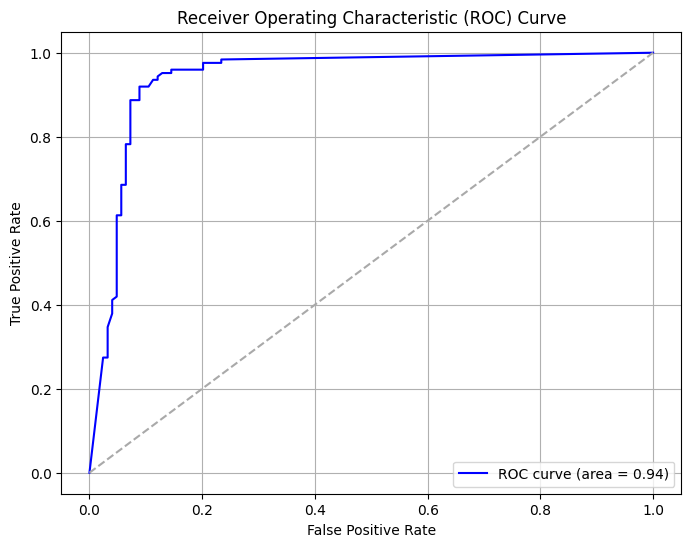

In [11]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [24]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

# Predictions
y_pred = model_xgb.predict(X_test)
y_pred_proba = model_xgb.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("AUROC:", auroc)
print("Precision:", precision)

Accuracy: 0.8467741935483871
AUROC: 0.9324596774193549
Precision: 0.8909090909090909


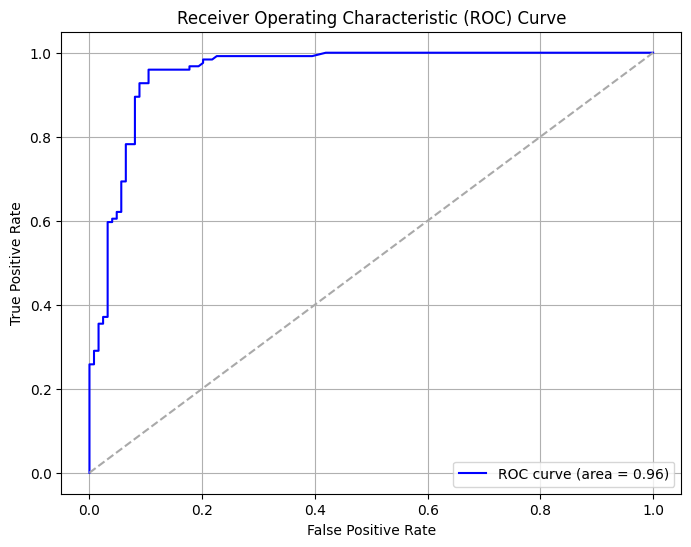

In [13]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()